## Baseline classification results for catinous

In [209]:
from pytorch_lightning import Trainer
#from catinous.CatsinomModel import CatsinomModel
from catinous.CatsinomDataset import CatsinomDataset
import catinous.CatsinomModelGramCache as catsmodel
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, auc, roc_curve, accuracy_score
import pandas as pd
import seaborn as sns
from catinous.CatsinomDataset import Catsinom_Dataset_CatineousStream as StreamedDS
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pickle
from py_jotools import mut
import SimpleITK as sitk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

# Loading test sets

In [153]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='test', res='lr'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='test', res='hr'), batch_size=8, num_workers=4)
test_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='test', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

## Testing LR model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_lr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


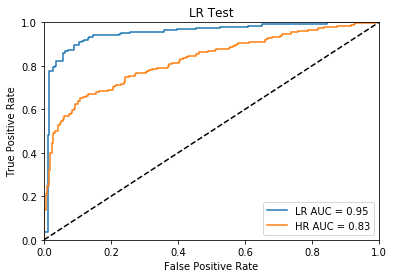

In [26]:
hparams={'continous':False,
         'datasetfile': 'catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR')

## Testing LR-base model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_lr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


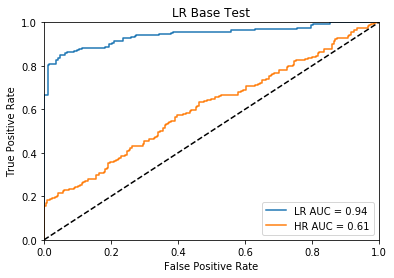

In [27]:
hparams={'continous':False,
         'datasetfile': 'catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR Base')

## Testing HR Model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


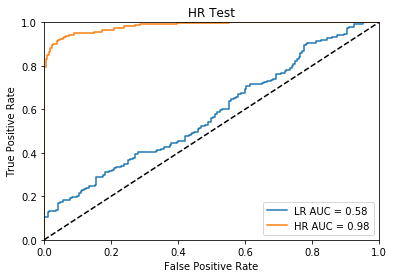

In [28]:
hparams={'continous':False,
         'datasetfile': 'catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR')

## Testing HR-base model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


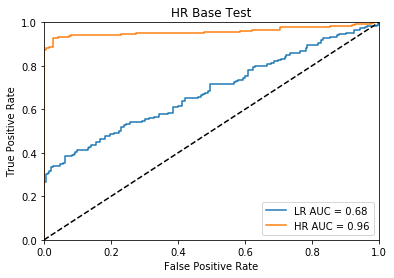

In [29]:
hparams={'continous':False,
         'datasetfile': 'catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR Base')

## Testing combined model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_combined_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


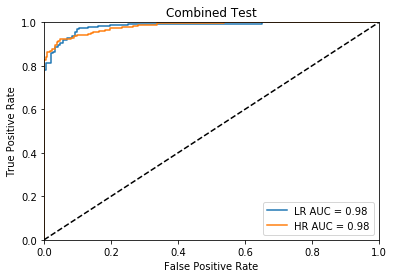

In [24]:
hparams={'continous':False,
         'datasetfile': 'catsinom_combined_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='Combined')

## Testing LR-HR

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': 'batch_lr_train-base_train_1_013cced594.pt',
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


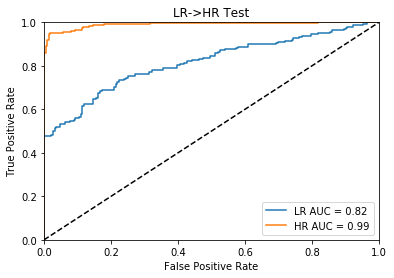

In [25]:
hparams={'continous':False,
         'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000,
        'base_model': 'batch_lr_train-base_train_1_013cced594.pt'}

model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR->HR')

## Testing HR-LR

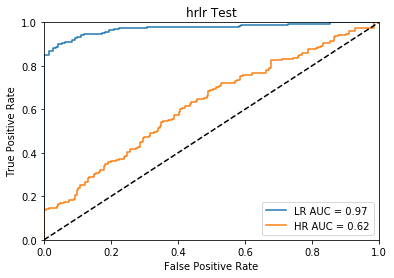

In [5]:
plot_test_roc('hrlr', {'LR': test_lr, 'HR': test_hr}, device)

# Continous training random cache

In [210]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

def test_metrices(hparams, datasets, device):
    roc_aucs = dict()
    accuracies = dict()
    fprs = dict()
    tprs = dict()
    
    for i in range(1, 6):
        hparams['run_postfix'] = i
        model, logs, df_cache, modelpath = catsmodel.trained_model(hparams)
        model = model.to(device) #not sure why this is needed, model should be on device
        model.freeze()
        
        for ds in datasets:
            target, output = test_model(model, datasets[ds], device)
    
            #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        
            output_bin = [int(o>0.5) for o in output]
                        
            fpr, tpr, _ = roc_curve(target, output)
            
            if i==1:
                roc_aucs[ds] = list()
                fprs[ds] = list()
                tprs[ds] = list()
                accuracies[ds] = list()
                
            roc_aucs[ds].append(auc(fpr, tpr))
            accuracies[ds].append(accuracy_score(target, output_bin))
            fprs[ds].append(fpr)
            tprs[ds].append(tpr)
            
    return (roc_aucs, accuracies, fprs, tprs)

In [226]:
val_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='val', res='lr'), batch_size=8, num_workers=4)
val_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='val', res='hr'), batch_size=8, num_workers=4)
val_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='val', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [212]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts2_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':64,
            'force_misclassified':True}

roc_aucs, accuracies, fprs, tprs = test_metrices(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts}, device)

{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 1}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_360219d87b.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 2}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_8b3923dedb.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 3}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_dd9880f7f2.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 4}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c6547043a5.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 5}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_18e2cfb10b.pt


In [220]:
print('LR', np.array(roc_aucs['LR']).mean(), np.array(roc_aucs['LR']).std())
print('HR', np.array(roc_aucs['HR']).mean(), np.array(roc_aucs['HR']).std())
print('HR TS', np.array(roc_aucs['HR TS']).mean(), np.array(roc_aucs['HR TS']).std())

LR 0.9048831569664904 0.034291930314649346
HR 0.894866394629459 0.015766274087477106
HR TS 0.945335919590901 0.06122438046275573


In [228]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts2_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':64,
            'force_misclassified':True}

roc_aucs_val, accuracies_val, fprs, tprs = test_metrices(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts}, device)

print('LR', np.array(roc_aucs_val['LR']).mean(), np.array(roc_aucs_val['LR']).std())
print('HR', np.array(roc_aucs_val['HR']).mean(), np.array(roc_aucs_val['HR']).std())
print('HR TS', np.array(roc_aucs_val['HR TS']).mean(), np.array(roc_aucs_val['HR TS']).std())

{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 1}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_360219d87b.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 2}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_8b3923dedb.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 3}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_dd9880f7f2.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 4}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c6547043a5.pt
{'continous': True, 'use_cache': True, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'cachemaximum': 64, 'force_misclassified': True, 'run_postfix': 5}


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_18e2cfb10b.pt
LR 0.9121355397951143 0.024474086664674023
HR 0.8885299156709611 0.009589862033336819
HR TS 0.9496562312262199 0.07041381743359161


# continous without cache

In [222]:
hparams={'continous': True,
             'use_cache':False,
            'datasetfile': 'catsinom_combined_dsts2_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30}

roc_aucs_wo_cache, accuracies_wo_cache, fprs, tprs = test_metrices(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts}, device)

{'continous': True, 'use_cache': False, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'run_postfix': 1}
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_cf322e6cd1.pt
{'continous': True, 'use_cache': False, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'run_postfix': 2}
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_894ad2e0c2.pt
{'continous': True, 'use_cache': False, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.pt', 'val_check_interval': 30, 'run_postfix': 3}
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_3e2816501d.pt
{'continous': True, 'use_cache': False, 'datasetfile': 'catsinom_combined_dsts2_dataset.csv', 'base_model': 'batch_lr_base_train_1_2d20289ac9.

In [223]:
print('LR', np.array(roc_aucs_wo_cache['LR']).mean(), np.array(roc_aucs_wo_cache['LR']).std())
print('HR', np.array(roc_aucs_wo_cache['HR']).mean(), np.array(roc_aucs_wo_cache['HR']).std())
print('HR TS', np.array(roc_aucs_wo_cache['HR TS']).mean(), np.array(roc_aucs_wo_cache['HR TS']).std())

LR 0.606630291005291 0.01774751777702316
HR 0.8950024132332939 0.013386021191131013
HR TS 0.9972932463410332 0.0005877233552899827


# Result Figures

In [3]:
df_wo_cache = None
for i in range(3):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_wo_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_wo_cache is None:
        df_wo_cache = df_temp
    else:
        df_wo_cache = df_wo_cache.append(df_temp)
        
        
df_randomcache = None

for i in range(3):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_random_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_randomcache is None:
        df_randomcache = df_temp
    else:
        df_randomcache = df_randomcache.append(df_temp)


In [4]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = streamedDS.df.res == 'lr'

In [5]:
newcmp = ListedColormap([sns.color_palette()[1], sns.color_palette()[0]], name='OrangeBlue')

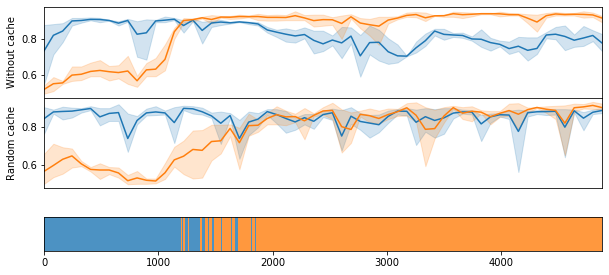

In [6]:
fig, ax = plt.subplots(3,1, figsize=(10, 5))

plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0])
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0])
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 60)
ax[0].set_ylabel('Without cache')

sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 60)
ax[1].set_ylabel('Random cache')

ax[2].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=0.8)
ax[2].get_yaxis().set_visible(False)
ax[2].get_yaxis()

# Analyze Cache

In [12]:
def plot_cache_imgs(df):
    imgs = []
    for fp in df.filepath:
        simg = sitk.ReadImage(os.path.join('/project/catinous/cat_data', fp))
        img = sitk.GetArrayFromImage(simg)

        img = mut.intensity_window(img, low=-1024, high=400)
        img = mut.norm01(img)
        imgs.append(img[0])

    mut.mimshow(np.asarray(imgs), nslic=len(df))

In [13]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_basemodel_lr_cache_tf07_1_ceeb20f250.csv')

In [14]:
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr,1,1,1
hr_ts,22,22,22
lr,41,41,41


In [15]:
df_cache.groupby('label').count()

,filepath,res,traincounter
label,,,
0,32,32,32
1,32,32,32


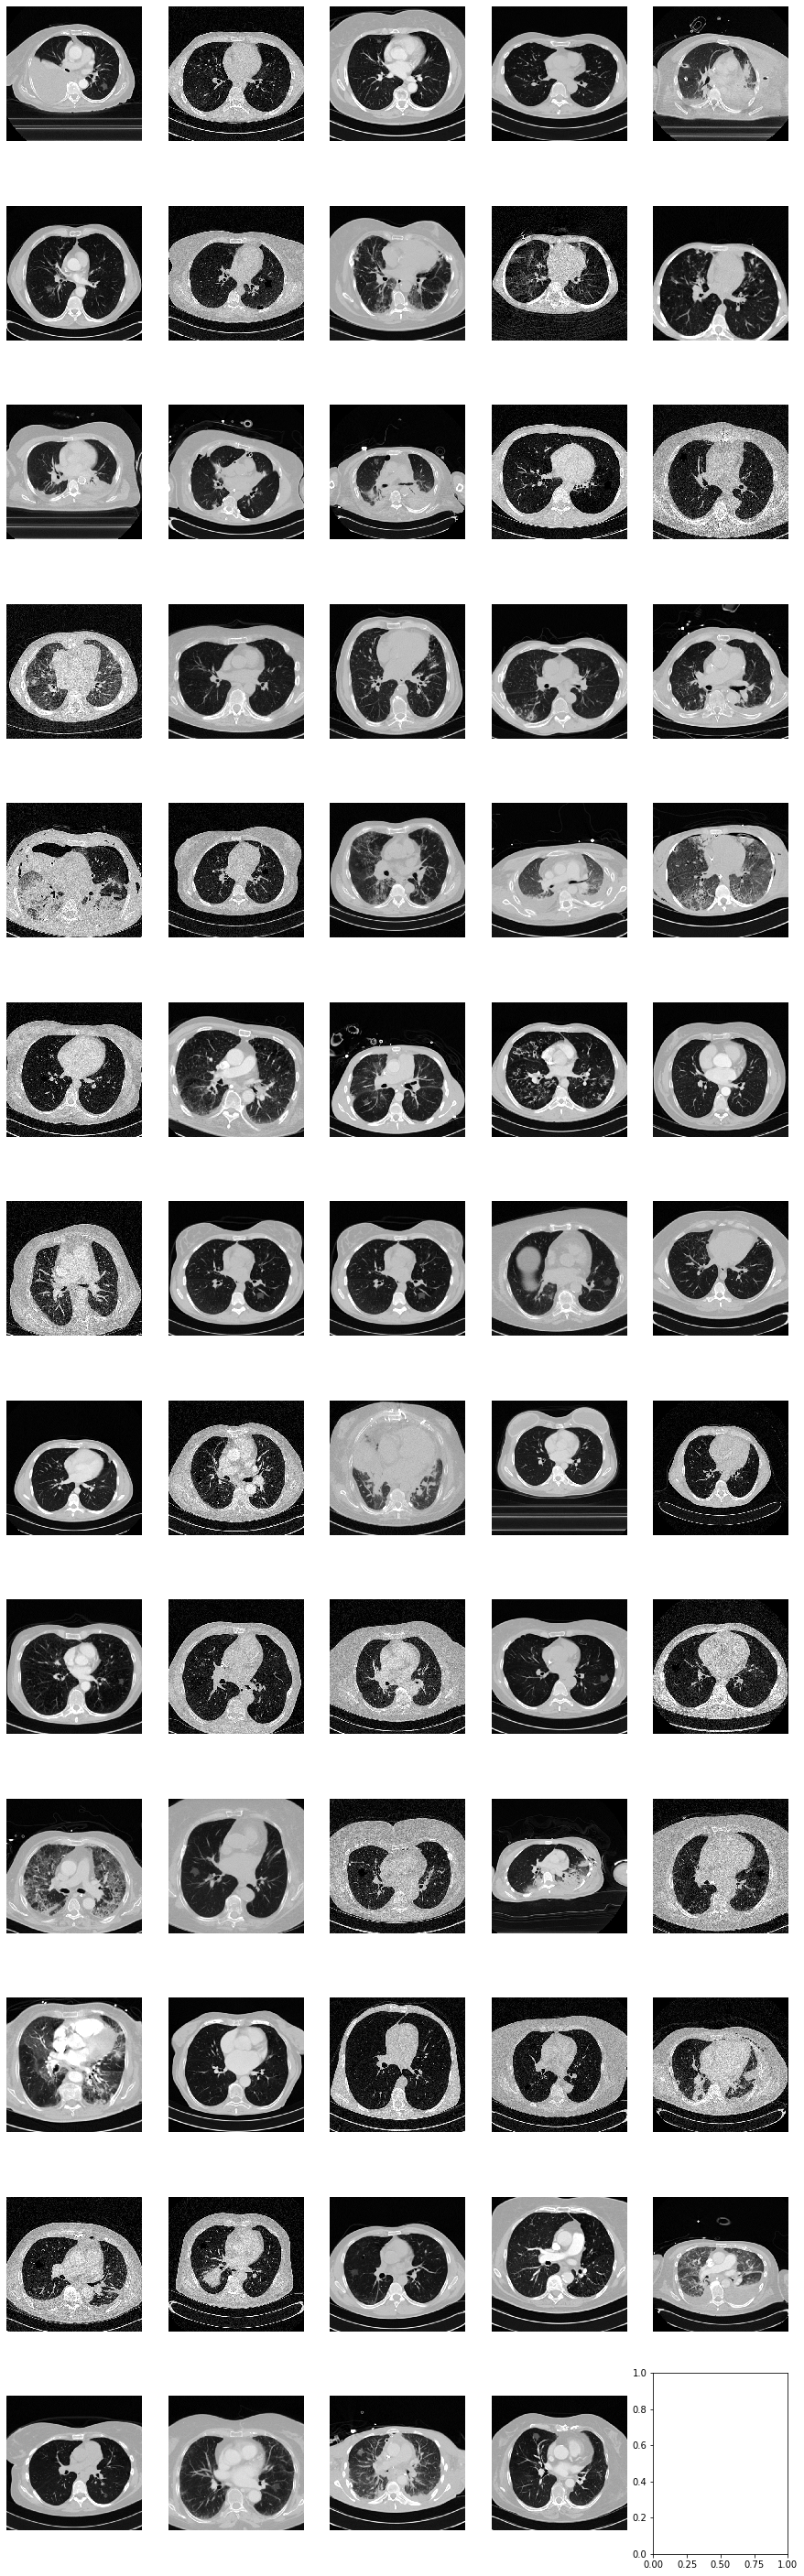

In [16]:
plot_cache_imgs(df_cache)

461 839 839 999 2342


In [4]:
%debug

> /home/mperkonigg/.local/lib/python3.6/site-packages/pandas/core/indexing.py(2088)_validate_integer()
   2086         len_axis = len(self.obj._get_axis(axis))
   2087         if key >= len_axis or key < -len_axis:
-> 2088             raise IndexError("single positional indexer is out-of-bounds")
   2089 
   2090     def _getitem_tuple(self, tup):



ipdb>  old_idx


*** NameError: name 'old_idx' is not defined


ipdb>  combds


*** NameError: name 'combds' is not defined


ipdb>  


*** NameError: name 'combds' is not defined


ipdb>  exit


466 840 840 999 2338


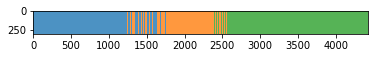

In [41]:
res

array([0, 0, 0, ..., 2, 2, 2])

In [34]:
streamedDS.df.res

0          lr
1          lr
2          lr
3          lr
4          lr
        ...  
4439    hr_ts
4440    hr_ts
4441    hr_ts
4442    hr_ts
4443    hr_ts
Name: res, Length: 4444, dtype: category
Categories (3, object): [hr, hr_ts, lr]

In [34]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not catsmodel.is_cached(base_params[-1]):
            print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)    
        else:
            _, df_temp, _, _ = catsmodel.trained_model(base_params[-1])
            df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

In [224]:
data = 'catsinom_combined_dsts_dataset.csv'
# data = 'catsinom_combined_dataset.csv'


# df_randomcache = pd.DataFrame()
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts2_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':64,
            'force_misclassified':True}
df_randomcache = res_data_for_params(hparams)
              
# df_wo_cache = pd.DataFrame()
hparams={'continous': True,
         'use_cache':False,
            'datasetfile': 'catsinom_combined_dsts2_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30}
df_wo_cache = res_data_for_params(hparams)

INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_360219d87b.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_8b3923dedb.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_dd9880f7f2.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c6547043a5.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_18e2cfb10b.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_cf322e6cd1.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_894ad2e0c2.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_3e2816501d.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_19f859e79f.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_dc0e510ecc.pt


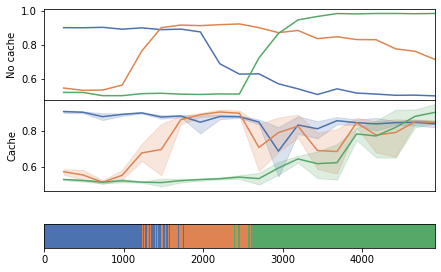

In [225]:

newcmp = ListedColormap(sns.color_palette("deep", 3))
sns.set_palette(sns.color_palette("deep", 3))

fig, ax = plt.subplots(3,1, figsize=(7, 5))

plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_wo_cache, y='val_acc_hr_ts', x='idx', ax=ax[0], err_style=None)
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 20)
ax[0].set_ylabel('No cache')

sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr_ts', x='idx', ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 20)
ax[1].set_ylabel('Cache')

ax[2].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=1.0)
ax[2].get_yaxis().set_visible(False)
ax[2].get_yaxis()

In [80]:
np.random.binomial(1,min(5/((10)*2),1))

1

In [77]:
min(5/((10)*2),1)

0.25

In [230]:
res = ['LR', 'LR', 'LR']
res2 = ['LR', 'LR', 'HR']

In [233]:
np.unique(res2)

array(['HR', 'LR'], dtype='<U2')

In [236]:
if 'HR' in res:
    print('lr')